In [1]:
%load_ext autoreload
%autoreload 2


# Build a baseline model

We are interested in testing the following alternative hypothesis:
1. Higher square footage increases home sale price.
2. The house filling a higher proportion of the overall lot decreases home sale price
3. The cost per square foot is lower in duplexes than in single-family homes

Therefore we have decided that our baseline model should include the following features:
1. Total living space, squarefeet
2. Total lot size, squarefeet
3. The ratio of house footprint to lot size. To engineer this feature we assumed the footprint was reasonably represented by the attached garage space+the first floor square feet divided by the lot size. 
4. If the house is a duplex, or not


## Cleaning Thought Process

Some top level thoughts are: we removed sales below 10,000 USD, as these are most likely erroneous or a result from a sale from family to family. There are some mobile homes in the 30,000-50,000 USD range, and so we decided to err on the lower side as perhaps there are legitimate sales in the 10,000-20,000 USD range. 

Also due to our business goals, of helping millennials buy their first home, we removed saleprices outside of two standard deviations of the mean. This excluded houses sold for more than 2.5 million USD. Our reasoning being that houses beyond that are certainly well outside the ability of a first-time buyer to achieve.

In [14]:
from src.utilities import kc_housing as kc
# df = kc.pullsqldata()
# df_clean = kc.clean_data_intial(df)
# x = df_clean.drop(columns = 'saleprice')
# y = df_clean['saleprice']

In [2]:
baseline_features = ['sqfttotliving','sqftlot','footprint_ratio','duplex']
kc.make_housing_model(baseline_features, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     3228.
Date:                Fri, 06 Dec 2019   Prob (F-statistic):               0.00
Time:                        09:52:53   Log-Likelihood:            -3.9009e+05
No. Observations:               27813   AIC:                         7.802e+05
Df Residuals:                   27808   BIC:                         7.802e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.884e+05   6113.559     30.822      0.000    1.76e+05       2e+05
sqfttotliving     226.2975      2.124    106.536      0.000     222.134     230.461
sqftlot            -0.2127      0.158     -1.344      0.179      -0.523       0.097
footprint_ratio  2.631e+05   1.77e+04     14.843      0.000    2.28e+05    2.98e+05
duplex            6.61e+04   1.62e+04      4.074      0.000    3.43e+04    9.79e+04
==============================================================================
Omnibus:                     3237.057   Durbin-Watson:                   0.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6388.669
Skew:                           0.749   Prob(JB):                         0.00
Kurtosis:                       4.807   Cond. No.                     1.78e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Check baseline model assumptions

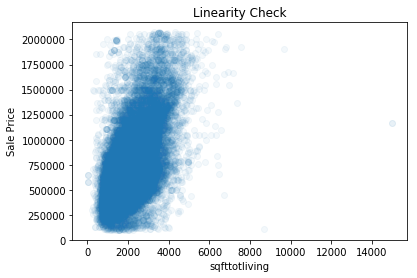

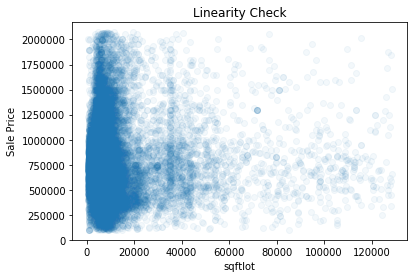

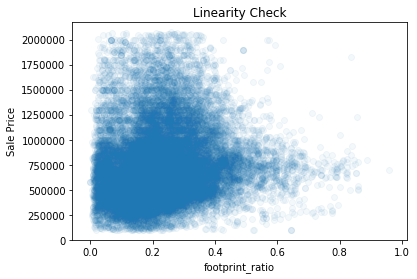

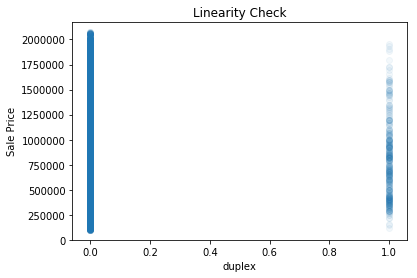

In [3]:
kc.check_feature_linearity(baseline_features, x, y)

In [ ]:
kc.check_feature_resid_dist(baseline_features, x, y)

In [ ]:
kc.check_feature_heteros(baseline_features, x, y)

### Because the sqftlot feature seems to violoate assumption of linearity, lets remove it from the model

In [ ]:
baseline_features = ['sqfttotliving','footprint_ratio','duplex']
kc.make_housing_model(baseline_features, x, y)

# All RE listings include bath count, so lets see how that contributes to our model:

In [ ]:
list_of_feat =['bath_total_count', 'sqfttotliving','footprint_ratio','duplex']
kc.make_housing_model(list_of_feat,kc.engineer_total_baths(x),y)

### Total bathrooms does not seem to add much benefit to our model, and it has an elevated p score, so we will not include it in our model. 

# What about the age of the house?

In [ ]:
list_of_feat =['sqfttotliving','footprint_ratio','duplex', 'age']
kc.make_housing_model(list_of_feat,kc.engineer_age(x),y)

### Age seems to add a notible boost in the model,and it has a low p score, lets test its assumptions:

In [ ]:
kc.check_feature_heteros(['age'],x,y)
kc.check_feature_linearity(['age'],x,y)
kc.check_feature_resid_dist(['age'],x,y)

### It appears that age violates the assumption of linearity, so although it adds some strength to out R^2 value, we will leave it out of our improved model. 

# What about porches/decks?

In [ ]:
list_of_feat =['sqfttotliving','footprint_ratio','duplex', 'porch_sqft_total']
kc.make_housing_model(list_of_feat,kc.engineer_total_porch_space(x),y)

The R^2 value remains unchanged, and the porch feature's coefficient is relativley small, so we will not include it in the model. 

### Once again, it seems the porch space violates the assumption of linearity, so we will not include it in our final model. 

# How about zipcode? 

In [4]:
#create model with zipcodes and other baseline features

list_of_feat =['sqfttotliving','footprint_ratio','duplex']
kc.make_zipcode_model(df_clean, list_of_feat)

/Users/tree/ds/proj2/king_county_housing/src/utilities/kc_housing.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dropped_rows['zipcode'] = dropped_rows['zipcode'].map(lambda x: x[0:5])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     652.3
Date:                Fri, 06 Dec 2019   Prob (F-statistic):               0.00
Time:                        09:53:24   Log-Likelihood:            -3.0967e+05
No. Observations:               22804   AIC:                         6.195e+05
Df Residuals:                   22719   BIC:                         6.202e+05
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            7.164e+05   1.92e+05      3.741      0.000    3.41e+05    1.09e+06
zip_98001       -6.896e+05   1.92e+05     -3.598      0.000   -1.07e+06   -3.14e+05
zip_98002        -6.74e+05   1.92e+05     -3.515      0.000   -1.05e+06   -2.98e+05
zip_98003       -6.727e+05   1.92e+05     -3.509      0.000   -1.05e+06   -2.97e+05
zip_98004        2.192e+05   1.92e+05      1.141      0.254   -1.57e+05    5.96e+05
zip_98005       -1.161e+04   1.92e+05     -0.060      0.952   -3.88e+05    3.65e+05
zip_98006       -1.268e+05   1.92e+05     -0.662      0.508   -5.03e+05    2.49e+05
zip_98007       -2.139e+05   1.92e+05     -1.113      0.266   -5.91e+05    1.63e+05
zip_98008       -2.189e+05   1.92e+05     -1.141      0.254   -5.95e+05    1.57e+05
zip_98009       -6.632e+05   2.71e+05     -2.449      0.014   -1.19e+06   -1.32e+05
zip_98010       -5.733e+05   1.92e+05     -2.980      0.003    -9.5e+05   -1.96e+05
zip_98011       -4.248e+05   1.92e+05     -2.213      0.027   -8.01e+05   -4.86e+04
zip_98014       -5.089e+05   1.92e+05     -2.646      0.008   -8.86e+05   -1.32e+05
zip_98019       -5.249e+05   1.92e+05     -2.733      0.006   -9.01e+05   -1.48e+05
zip_98022       -6.612e+05   1.92e+05     -3.448      0.001   -1.04e+06   -2.85e+05
zip_98023        -6.89e+05   1.92e+05     -3.596      0.000   -1.06e+06   -3.13e+05
zip_98024       -4.917e+05   1.93e+05     -2.543      0.011   -8.71e+05   -1.13e+05
zip_98027       -3.349e+05   1.92e+05     -1.746      0.081   -7.11e+05     4.1e+04
zip_98028       -4.505e+05   1.92e+05     -2.348      0.019   -8.26e+05   -7.45e+04
zip_98029       -2.456e+05   1.92e+05     -1.280      0.201   -6.22e+05    1.31e+05
zip_98030       -6.573e+05   1.92e+05     -3.427      0.001   -1.03e+06   -2.81e+05
zip_98031       -6.511e+05   1.92e+05     -3.396      0.001   -1.03e+06   -2.75e+05
zip_98032       -6.684e+05   1.92e+05     -3.483      0.000   -1.04e+06   -2.92e+05
zip_98033        1.056e+04   1.92e+05      0.055      0.956   -3.65e+05    3.86e+05
zip_98034       -3.252e+05   1.92e+05     -1.697      0.090   -7.01e+05    5.05e+04
zip_98038       -6.058e+05   1.92e+05     -3.161      0.002   -9.81e+05    -2.3e+05
zip_98039        4.499e+05   1.98e+05      2.275      0.023    6.23e+04    8.38e+05
zip_98040        1.406e+05   1.92e+05      0.733      0.464   -2.35e+05    5.17e+05
zip_98042       -6.525e+05   1.92e+05     -3.406      0.001   -1.03e+06   -2.77e+05
zip_98045       -4.468e+05   1.92e+05     -2.330      0.020   -8.23e+05    -7.1e+04
zip_98047       -6.897e+05   1.93e+05     -3.571      0.000   -1.07e+06   -3.11e+05
zip_98050       -4.517e+05   2.21e+05     -2.043      0.041   -8.85e+05   -1.83e+04
zip_98051       -6.125e+05   1.95e+05     -3.141      0.002   -9.95e+05    -2.3e+05
zip_98052       -2.023e+05   1.92e+05     -1.055      0.291

### LOCATION LOCATION LOCATION wow, that added a bunch to our R^2! Lets check the assumptions: 

In [ ]:
kc.check_zip_code_res_normality(df_clean)

Great, Zip Codes seem to meet our assumptions, lets include them !

# We now added features relating to views, the best predicting waterfront feature, as well as heatsource and the surface of the access street

We tried a model with ALL features not dropped by our cleaning function, and a few stood out. We wanted to explore the street surface and heatsource features, as they were categorical. Upon looking closely at them, they didn't actually improve our R^2 when added alongside the view and waterfront features. And when dropping them, they did not decrease our ability to predict

We did not include some view features based on assumptions and correlation. For example, houses in King County that have views of Pugent Sound are expected to also have views of the Olympics. The Olympics proved to be a better predictor so we used that instead of the Puget Sound feature. The values for all of the view features are continuous, no view is 0, fair is 1, excellent is 4.


In [5]:
## This is our list of features for the new model
new_model = df_clean[['saleprice','sqfttotliving', 'footprint_ratio', 'duplex', 'wfntlocation', 'lakesammamish', 'seattleskyline', 'olympics', 'mtrainier', 'streetsurface', 'heatsource', 'zipcode']]

In [40]:
# this one hot encodes the zipcode column
zip_df = kc.zip_code_df(new_model)[0]

/Users/tree/ds/proj2/king_county_housing/src/utilities/kc_housing.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dropped_rows['zipcode'] = dropped_rows['zipcode'].map(lambda x: x[0:5])


In [41]:
# below is our new model with the One Hot Encoded zip codes
import statsmodels.api as sm
Y = zip_df['saleprice']
X = zip_df.drop(['saleprice'], axis=1)
X_int = sm.add_constant(X)
model = sm.OLS(Y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     635.4
Date:                Fri, 06 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:18:25   Log-Likelihood:            -3.0923e+05
No. Observations:               22804   AIC:                         6.186e+05
Df Residuals:                   22712   BIC:                         6.194e+05
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            7.263e+05   1.88e+05      3.862      0.000    3.58e+05    1.09e+06
sqfttotliving     191.4519      1.674    114.344      0.000     188.170     194.734
footprint_ratio  -1.05e+05   1.34e+04     -7.810      0.000   -1.31e+05   -7.86e+04
duplex          -9374.8496   1.06e+04     -0.887      0.375   -3.01e+04    1.13e+04
wfntlocation     2.112e+04   1517.987     13.915      0.000    1.81e+04    2.41e+04
lakesammamish    1.051e+05   8112.652     12.959      0.000    8.92e+04    1.21e+05
seattleskyline   3.593e+04   6948.629      5.171      0.000    2.23e+04    4.96e+04
olympics         6.512e+04   3415.175     19.068      0.000    5.84e+04    7.18e+04
mtrainier        2.225e+04   5676.876      3.920      0.000    1.11e+04    3.34e+04
streetsurface    7902.2946   7635.321      1.035      0.301   -7063.457    2.29e+04
heatsource        275.8667   2151.753      0.128      0.898   -3941.717    4493.450
zip_98001       -7.066e+05   1.88e+05     -3.758      0.000   -1.08e+06   -3.38e+05
zip_98002       -6.924e+05   1.88e+05     -3.681      0.000   -1.06e+06   -3.24e+05
zip_98003       -6.953e+05   1.88e+05     -3.697      0.000   -1.06e+06   -3.27e+05
zip_98004        2.113e+05   1.89e+05      1.121      0.262   -1.58e+05    5.81e+05
zip_98005        -1.88e+04   1.89e+05     -0.100      0.921   -3.88e+05    3.51e+05
zip_98006        -1.61e+05   1.88e+05     -0.856      0.392    -5.3e+05    2.08e+05
zip_98007        -2.24e+05   1.89e+05     -1.187      0.235   -5.94e+05    1.46e+05
zip_98008       -2.637e+05   1.88e+05     -1.402      0.161   -6.33e+05    1.05e+05
zip_98009        -6.71e+05   2.66e+05     -2.526      0.012   -1.19e+06    -1.5e+05
zip_98010       -6.119e+05   1.89e+05     -3.242      0.001   -9.82e+05   -2.42e+05
zip_98011       -4.364e+05   1.88e+05     -2.318      0.020   -8.06e+05   -6.74e+04
zip_98014       -5.314e+05   1.89e+05     -2.816      0.005   -9.01e+05   -1.62e+05
zip_98019       -5.406e+05   1.88e+05     -2.869      0.004    -9.1e+05   -1.71e+05
zip_98022       -6.808e+05   1.88e+05     -3.618      0.000   -1.05e+06   -3.12e+05
zip_98023       -7.062e+05   1.88e+05     -3.757      0.000   -1.07e+06   -3.38e+05
zip_98024       -5.177e+05    1.9e+05     -2.729      0.006    -8.9e+05   -1.46e+05
zip_98027       -3.449e+05   1.88e+05     -1.833      0.067   -7.14e+05    2.38e+04
zip_98028       -4.622e+05   1.88e+05     -2.456      0.014   -8.31e+05   -9.33e+04
zip_98029       -2.616e+05   1.88e+05     -1.390      0.165   -6.31e+05    1.07e+05
zip_98030       -6.691e+05   1.88e+05     -3.556      0.000   -1.04e+06      -3e+05
zip_98031       -6.636e+05   1.88e+05     -3.528      0.000   -1.03e+06   -2.95e+05
zip_98032       -6.813e+05   1.88e+05     -3.619      0.000   -1.05e+06   -3.12e+05
zip_98033       -1.061e+04   1.88e+05     -0.056      0.955

### Heatsource and Streetsurface
We found that dropping both streetsurface and heatsource did not affect the predictive capacities of the model
at all. This is also true after One Hot Encoding them (not contained in this workbook)

In [45]:
# this drops streetsurface and heatsource, to demonstrate that it does not affect our model
Y = zip_df['saleprice']
X = zip_df.drop(['saleprice', 'streetsurface', 'heatsource'], axis=1)
X_int = sm.add_constant(X)
model = sm.OLS(Y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     649.7
Date:                Fri, 06 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:20:49   Log-Likelihood:            -3.0923e+05
No. Observations:               22804   AIC:                         6.186e+05
Df Residuals:                   22714   BIC:                         6.194e+05
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            7.349e+05   1.88e+05      3.911      0.000    3.67e+05     1.1e+06
sqfttotliving     191.4709      1.672    114.537      0.000     188.194     194.748
footprint_ratio -1.069e+05   1.33e+04     -8.031      0.000   -1.33e+05   -8.08e+04
duplex          -9223.4056   1.06e+04     -0.873      0.382   -2.99e+04    1.15e+04
wfntlocation     2.119e+04   1515.878     13.982      0.000    1.82e+04    2.42e+04
lakesammamish     1.05e+05   8108.962     12.945      0.000    8.91e+04    1.21e+05
seattleskyline   3.593e+04   6948.406      5.171      0.000    2.23e+04    4.95e+04
olympics         6.511e+04   3415.093     19.066      0.000    5.84e+04    7.18e+04
mtrainier        2.242e+04   5674.629      3.950      0.000    1.13e+04    3.35e+04
zip_98001       -7.057e+05   1.88e+05     -3.754      0.000   -1.07e+06   -3.37e+05
zip_98002       -6.921e+05   1.88e+05     -3.680      0.000   -1.06e+06   -3.23e+05
zip_98003       -6.949e+05   1.88e+05     -3.695      0.000   -1.06e+06   -3.26e+05
zip_98004        2.113e+05   1.89e+05      1.121      0.262   -1.58e+05    5.81e+05
zip_98005       -1.867e+04   1.89e+05     -0.099      0.921   -3.88e+05    3.51e+05
zip_98006       -1.608e+05   1.88e+05     -0.855      0.393   -5.29e+05    2.08e+05
zip_98007       -2.236e+05   1.89e+05     -1.186      0.236   -5.93e+05    1.46e+05
zip_98008       -2.634e+05   1.88e+05     -1.400      0.161   -6.32e+05    1.05e+05
zip_98009       -6.705e+05   2.66e+05     -2.524      0.012   -1.19e+06    -1.5e+05
zip_98010        -6.11e+05   1.89e+05     -3.237      0.001   -9.81e+05   -2.41e+05
zip_98011       -4.361e+05   1.88e+05     -2.316      0.021   -8.05e+05    -6.7e+04
zip_98014       -5.309e+05   1.89e+05     -2.814      0.005   -9.01e+05   -1.61e+05
zip_98019       -5.396e+05   1.88e+05     -2.863      0.004   -9.09e+05    -1.7e+05
zip_98022       -6.802e+05   1.88e+05     -3.615      0.000   -1.05e+06   -3.11e+05
zip_98023       -7.059e+05   1.88e+05     -3.755      0.000   -1.07e+06   -3.37e+05
zip_98024        -5.17e+05    1.9e+05     -2.725      0.006   -8.89e+05   -1.45e+05
zip_98027        -3.44e+05   1.88e+05     -1.828      0.068   -7.13e+05    2.48e+04
zip_98028        -4.62e+05   1.88e+05     -2.455      0.014   -8.31e+05   -9.31e+04
zip_98029       -2.612e+05   1.88e+05     -1.387      0.165    -6.3e+05    1.08e+05
zip_98030       -6.687e+05   1.88e+05     -3.554      0.000   -1.04e+06      -3e+05
zip_98031       -6.632e+05   1.88e+05     -3.526      0.000   -1.03e+06   -2.94e+05
zip_98032       -6.811e+05   1.88e+05     -3.618      0.000   -1.05e+06   -3.12e+05
zip_98033       -1.039e+04   1.88e+05     -0.055      0.956   -3.79e+05    3.58e+05
zip_98034       -3.362e+05   1.88e+05     -1.788      0.074   -7.05e+05    3.23e+04
zip_98038       -6.214e+05   1.88e+05     -3.306      0.001

## Waterfront Location (wfntlocation) is categorical, let's One Hot Encode it!

In [43]:
def waterfront_ohe(final_model_df):
    """this is similar to the zipcode OHE function, but for the waterfront location feature"""
    final_model_df['wfntlocation'] = pd.Categorical(final_model_df['wfntlocation'])
    df_water = pd.get_dummies(final_model_df['wfntlocation'], prefix = 'water')

    #drop the column for houses with no waterfront location
    df_water.drop(columns = 'water_0.0', inplace = True) 
    
    
#join the zip code dataframe to the dataframe with the other predicitive features
    df_with_water_cols = final_model_df.join(df_water, how = 'inner')
    df_with_water_cols = df_with_water_cols.drop(['wfntlocation'], axis=1)
    return df_with_water_cols

In [37]:
model_with_wfnt_ohe = waterfront_ohe(zip_df)

In [38]:
Y = model_with_wfnt_ohe['saleprice']
X = model_with_wfnt_ohe.drop(['saleprice'], axis=1)
X_int = sm.add_constant(X)
model = sm.OLS(Y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     608.5
Date:                Fri, 06 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:17:05   Log-Likelihood:            -3.0906e+05
No. Observations:               22804   AIC:                         6.183e+05
Df Residuals:                   22706   BIC:                         6.191e+05
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            7.242e+05   1.87e+05      3.879      0.000    3.58e+05    1.09e+06
sqfttotliving     190.7275      1.664    114.599      0.000     187.465     193.990
footprint_ratio -1.054e+05   1.33e+04     -7.899      0.000   -1.32e+05   -7.92e+04
duplex          -1.342e+04   1.05e+04     -1.278      0.201    -3.4e+04    7160.793
lakesammamish    1.139e+05   9200.692     12.379      0.000    9.59e+04    1.32e+05
seattleskyline   3.826e+04   6906.941      5.539      0.000    2.47e+04    5.18e+04
olympics          6.17e+04   3452.619     17.871      0.000    5.49e+04    6.85e+04
mtrainier        1.957e+04   5661.590      3.456      0.001    8471.601    3.07e+04
streetsurface    1.081e+04   7589.573      1.424      0.154   -4068.529    2.57e+04
heatsource        872.3827   2136.580      0.408      0.683   -3315.460    5060.225
zip_98001       -7.062e+05   1.87e+05     -3.784      0.000   -1.07e+06    -3.4e+05
zip_98002       -6.904e+05   1.87e+05     -3.698      0.000   -1.06e+06   -3.24e+05
zip_98003       -6.951e+05   1.87e+05     -3.723      0.000   -1.06e+06   -3.29e+05
zip_98004        2.115e+05   1.87e+05      1.130      0.258   -1.55e+05    5.78e+05
zip_98005       -1.869e+04   1.87e+05     -0.100      0.920   -3.85e+05    3.48e+05
zip_98006       -1.639e+05   1.87e+05     -0.878      0.380    -5.3e+05    2.02e+05
zip_98007       -2.244e+05   1.87e+05     -1.199      0.231   -5.91e+05    1.43e+05
zip_98008       -2.637e+05   1.87e+05     -1.412      0.158    -6.3e+05    1.02e+05
zip_98009       -6.705e+05   2.64e+05     -2.543      0.011   -1.19e+06   -1.54e+05
zip_98010       -6.062e+05   1.87e+05     -3.235      0.001   -9.73e+05   -2.39e+05
zip_98011       -4.355e+05   1.87e+05     -2.330      0.020   -8.02e+05   -6.92e+04
zip_98014       -5.261e+05   1.87e+05     -2.809      0.005   -8.93e+05   -1.59e+05
zip_98019         -5.4e+05   1.87e+05     -2.887      0.004   -9.07e+05   -1.73e+05
zip_98022       -6.808e+05   1.87e+05     -3.645      0.000   -1.05e+06   -3.15e+05
zip_98023       -7.073e+05   1.87e+05     -3.791      0.000   -1.07e+06   -3.42e+05
zip_98024       -5.075e+05   1.88e+05     -2.695      0.007   -8.77e+05   -1.38e+05
zip_98027       -3.447e+05   1.87e+05     -1.846      0.065   -7.11e+05    2.14e+04
zip_98028       -4.635e+05   1.87e+05     -2.481      0.013    -8.3e+05   -9.73e+04
zip_98029       -2.616e+05   1.87e+05     -1.400      0.161   -6.28e+05    1.05e+05
zip_98030       -6.698e+05   1.87e+05     -3.586      0.000   -1.04e+06   -3.04e+05
zip_98031       -6.639e+05   1.87e+05     -3.556      0.000   -1.03e+06   -2.98e+05
zip_98032       -6.818e+05   1.87e+05     -3.648      0.000   -1.05e+06   -3.15e+05
zip_98033       -1.049e+04   1.87e+05     -0.056      0.955   -3.76e+05    3.55e+05
zip_98034       -3.392e+05   1.87e+05     -1.818      0.069

### That really added some predictability to the model! 
### Adjusted R^2 = 0.721!

However, we found that the error of the Waterfront Location to be too large given the modest predictability it provides (0.005), so we have decided to not include them in the final model

Now we need to test the assumptions of these new features

_______________________

//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
//anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


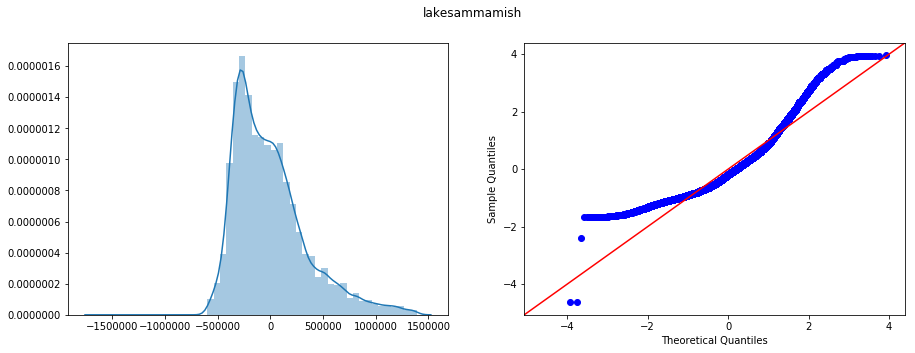

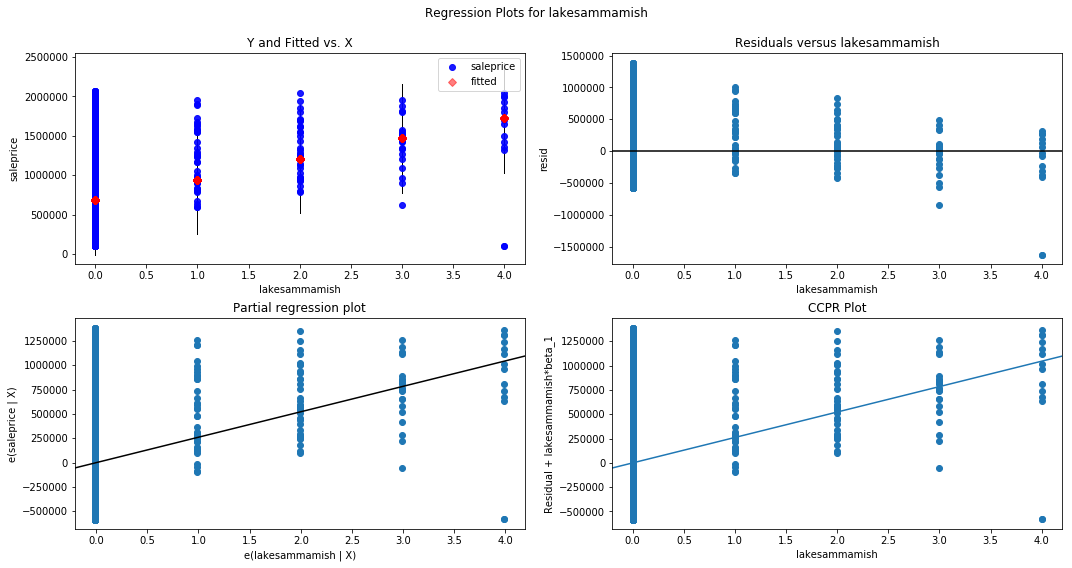

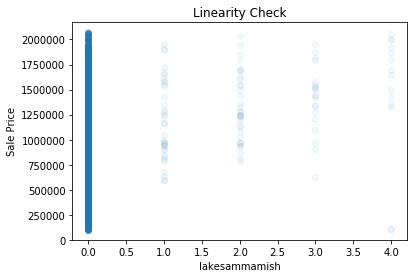

In [49]:
# this displays the normality assumption tests for lakesammamish
kc.check_feature_resid_dist(['lakesammamish'],X, Y)
kc.check_feature_heteros(['lakesammamish'], X, Y)
kc.check_feature_linearity(['lakesammamish'], X, Y)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
//anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


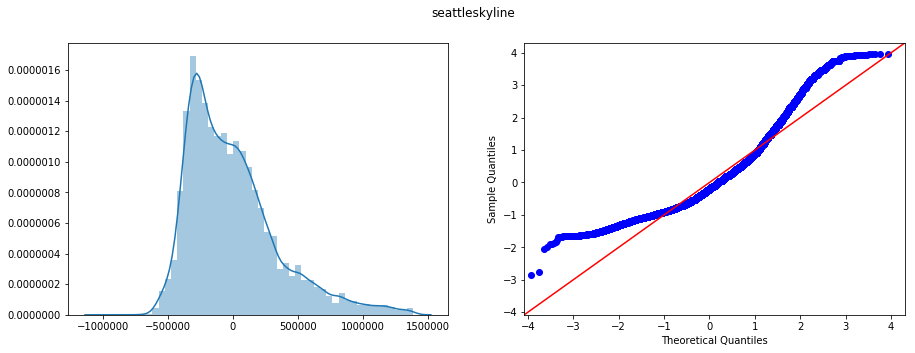

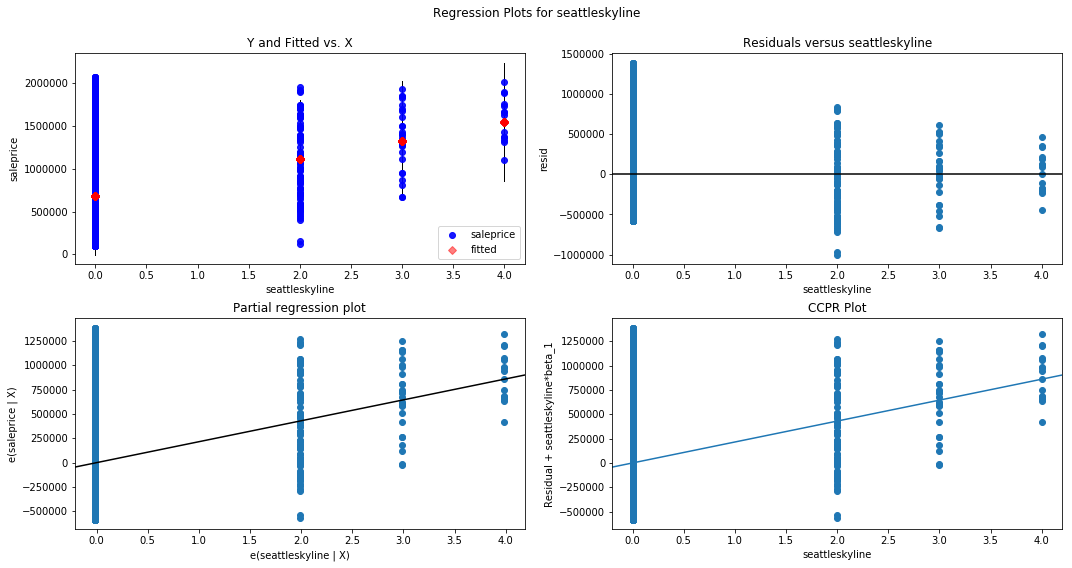

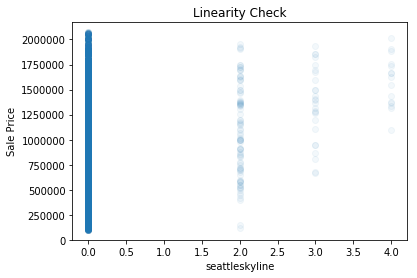

In [48]:
# this displays the normality assumption tests for seattleskyline
kc.check_feature_resid_dist(['seattleskyline'],X, Y)
kc.check_feature_heteros(['seattleskyline'], X, Y)
kc.check_feature_linearity(['seattleskyline'], X, Y)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
//anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


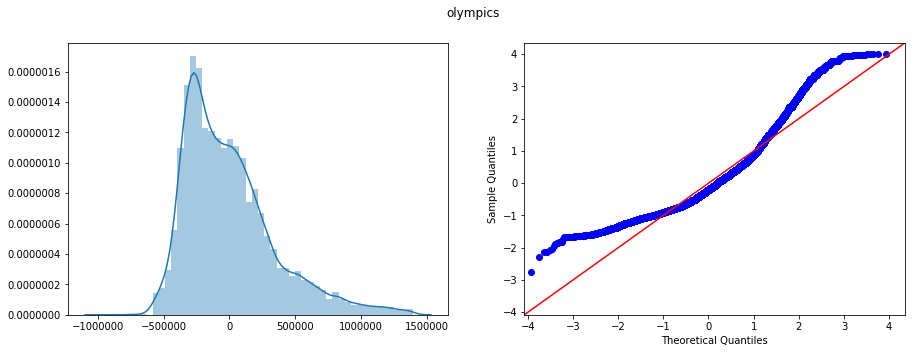

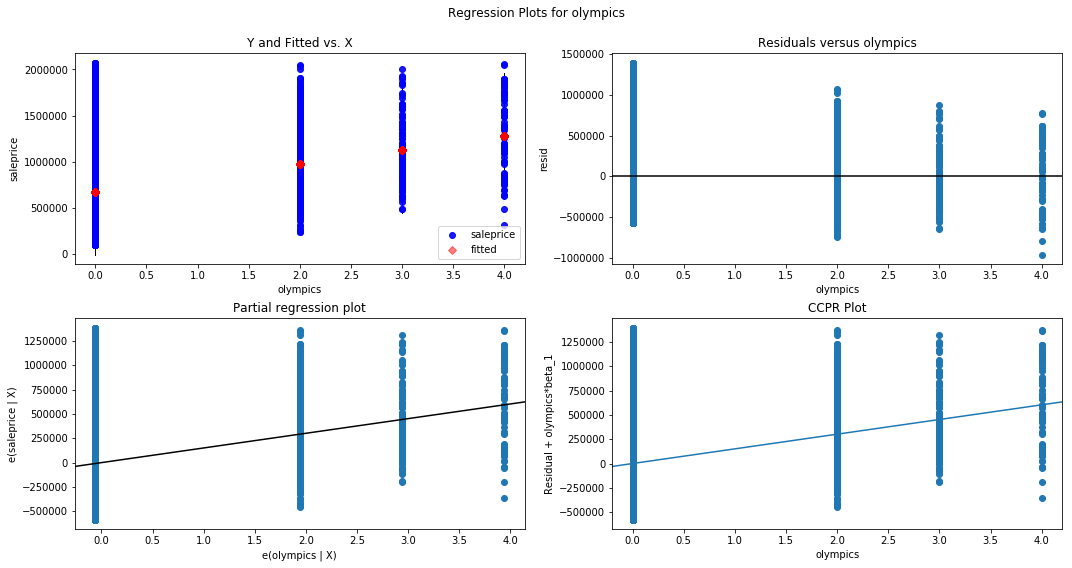

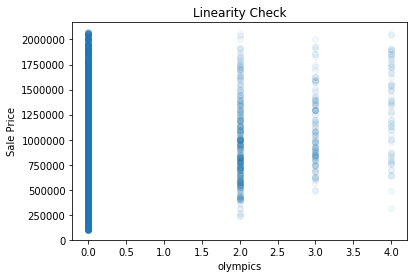

In [47]:
# this displays the normality assumption tests for olympics
kc.check_feature_resid_dist(['olympics'],X, Y)
kc.check_feature_heteros(['olympics'], X, Y)
kc.check_feature_linearity(['olympics'], X, Y)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
//anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


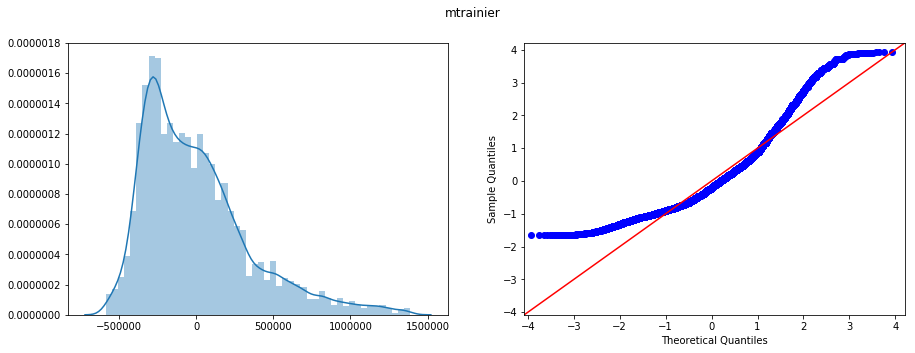

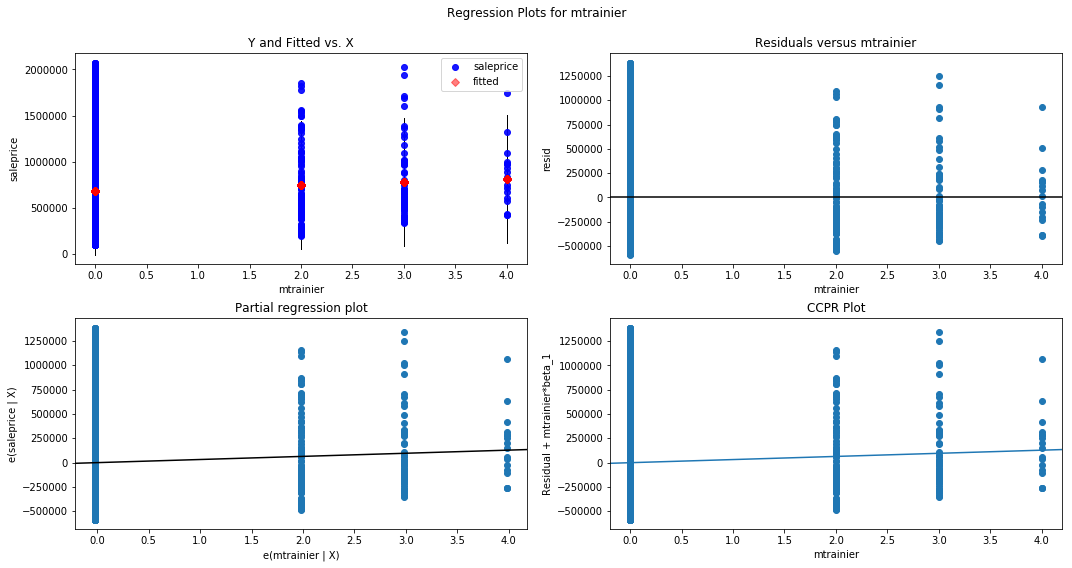

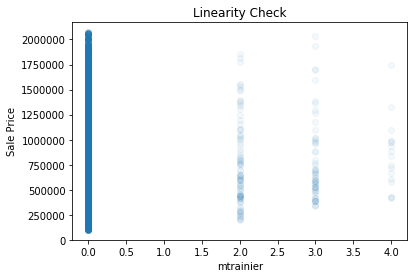

In [50]:
# this displays the assumption tests for mtrainier feature
kc.check_feature_resid_dist(['mtrainier'],X, Y)
kc.check_feature_heteros(['mtrainier'], X, Y)
kc.check_feature_linearity(['mtrainier'], X, Y)

__________________________________________________________________

# Final Model

Below is our final linear regression model.

In [51]:
Y = zip_df['saleprice']
X = zip_df.drop(['saleprice', 'streetsurface', 'heatsource', 'wfntlocation'], axis=1)
X_int = sm.add_constant(X)
model = sm.OLS(Y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     649.3
Date:                Fri, 06 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:29:12   Log-Likelihood:            -3.0932e+05
No. Observations:               22804   AIC:                         6.188e+05
Df Residuals:                   22715   BIC:                         6.195e+05
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            7.341e+05   1.89e+05      3.891      0.000    3.64e+05     1.1e+06
sqfttotliving     192.2035      1.678    114.542      0.000     188.914     195.493
footprint_ratio -1.245e+05   1.33e+04     -9.356      0.000   -1.51e+05   -9.84e+04
duplex          -8354.3532   1.06e+04     -0.788      0.431   -2.91e+04    1.24e+04
lakesammamish    1.134e+05   8121.235     13.960      0.000    9.75e+04    1.29e+05
seattleskyline     3.5e+04   6977.768      5.015      0.000    2.13e+04    4.87e+04
olympics         6.646e+04   3428.313     19.386      0.000    5.97e+04    7.32e+04
mtrainier          2.4e+04   5697.728      4.213      0.000    1.28e+04    3.52e+04
zip_98001       -6.978e+05   1.89e+05     -3.695      0.000   -1.07e+06   -3.28e+05
zip_98002       -6.851e+05   1.89e+05     -3.627      0.000   -1.06e+06   -3.15e+05
zip_98003       -6.912e+05   1.89e+05     -3.660      0.000   -1.06e+06   -3.21e+05
zip_98004        2.132e+05   1.89e+05      1.126      0.260   -1.58e+05    5.84e+05
zip_98005       -1.709e+04   1.89e+05     -0.090      0.928   -3.88e+05    3.54e+05
zip_98006       -1.589e+05   1.89e+05     -0.841      0.400   -5.29e+05    2.11e+05
zip_98007       -2.209e+05   1.89e+05     -1.166      0.244   -5.92e+05     1.5e+05
zip_98008       -2.599e+05   1.89e+05     -1.375      0.169    -6.3e+05     1.1e+05
zip_98009       -6.654e+05   2.67e+05     -2.494      0.013   -1.19e+06   -1.42e+05
zip_98010       -5.831e+05    1.9e+05     -3.076      0.002   -9.55e+05   -2.12e+05
zip_98011       -4.318e+05   1.89e+05     -2.283      0.022   -8.02e+05   -6.11e+04
zip_98014       -5.133e+05   1.89e+05     -2.709      0.007   -8.85e+05   -1.42e+05
zip_98019        -5.31e+05   1.89e+05     -2.806      0.005   -9.02e+05    -1.6e+05
zip_98022       -6.775e+05   1.89e+05     -3.586      0.000   -1.05e+06   -3.07e+05
zip_98023       -7.017e+05   1.89e+05     -3.717      0.000   -1.07e+06   -3.32e+05
zip_98024       -4.977e+05   1.91e+05     -2.612      0.009   -8.71e+05   -1.24e+05
zip_98027       -3.415e+05   1.89e+05     -1.807      0.071   -7.12e+05    2.88e+04
zip_98028       -4.569e+05   1.89e+05     -2.418      0.016   -8.27e+05   -8.65e+04
zip_98029       -2.571e+05   1.89e+05     -1.360      0.174   -6.28e+05    1.13e+05
zip_98030       -6.659e+05   1.89e+05     -3.524      0.000   -1.04e+06   -2.96e+05
zip_98031       -6.591e+05   1.89e+05     -3.489      0.000   -1.03e+06   -2.89e+05
zip_98032       -6.778e+05   1.89e+05     -3.585      0.000   -1.05e+06   -3.07e+05
zip_98033       -7972.0495   1.89e+05     -0.042      0.966   -3.78e+05    3.62e+05
zip_98034       -3.328e+05   1.89e+05     -1.763      0.078   -7.03e+05    3.73e+04
zip_98038        -6.13e+05   1.89e+05     -3.247      0.001   -9.83e+05   -2.43e+05
zip_98039        4.431e+05   1.95e+05      2.275      0.023

## Results

Our final model has an Adjusted R^2 of 0.714, with an F-statistic score of 649.3. There are some individual features that are not significant, but overall the model appears to be significant in its findings.